In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
M=50
N=40
dx=1
dy=1
dt=0.002
U= 1# Inlet speed u  
mu=1.81*1e-5#8.9*1e-4
rho=1.225#997
# mu=8.9*1e-4
# rho=997
KV=mu/rho
beta=dx/dy

In [3]:
C=U*dt/dx # Courant number
C

0.002

#### Initialization

In [13]:
u=np.zeros((M,N+1))#(5,5)
u[0,:]=U
v=np.zeros((M+1,N))# (6,4)
p=np.zeros((M+1,N+1)) # (6,5)

In [14]:
def update_V_F(u,v,p): # capital V is a vector, indicates u and v
    u_F=np.zeros((M,N+1))
    v_F=np.zeros((M+1,N))
    # loop for u
    for i in range(1,M-1):
        for j in range(1,N):
            # For A
            ududx = u[i,j]/dx * ( (u[i,j]+u[i+1,j])/2 - (u[i,j]+u[i-1,j])/2 )
            vdudy = 1/2 * ( (v[i,j]+v[i+1,j])/2 + (v[i,j-1]+v[i+1,j-1])/2 ) * 1/dy * ((u[i,j]+u[i,j+1])/2 - (u[i,j-1]+u[i,j])/2)
            Ax= -( ududx + vdudy )
            # For B
            d2u_dx2 = (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / (dx**2)
            d2u_dy2 = (u[i,j+1] - 2*u[i,j] + u[i, j-1]) / (dy**2)
            Bx = mu/rho * (d2u_dx2 + d2u_dy2)
            u_F[i,j] = u[i,j] + dt * (Ax + Bx)
    # loop for v
    for i in range(1,M):
        for j in range(1,N-1):
            # For A
            udvdx = 1/2 * ( (u[i,j]+u[i,j+1])/2 + (u[i-1,j]+u[i-1,j+1])/2 ) * 1/dx *( (v[i,j]+v[i+1,j])/2 - (v[i-1,j]+v[i,j])/2 )
            vdvdy = v[i,j]/dy * ( (v[i,j]+v[i,j+1])/2 - (v[i,j]+v[i,j-1])/2 )
            Ay = -( udvdx + vdvdy )
            # For B
            d2v_dx2 = (v[i+1,j] - 2*v[i,j] + v[i-1,j])/(dx**2)
            d2v_dy2 = (v[i,j+1] - 2*v[i,j] + v[i,j-1])/(dy**2)
            By = mu/rho * (d2v_dx2 + d2v_dy2)
            v_F[i,j] = v[i,j] + dt * (Ay + By)
    #BC for Domain
    #bottom wall
    u_F[:,0] = -u_F[:,1]
    v_F[:,0] = 0
    #top
    u_F[:,N] = -u_F[:,N-1]
    v_F[:,N-1] = 0

    #left -- inlet
    u_F[0,:] = U
    v_F[0,:]=-v_F[1,:]

    #outlet-- right
    u_F[M-1,:]=u_F[M-2,:]
    v_F[M,:]=v_F[M-1,:]
    
    # Updata cell
    # For u
    ## middle
    u_F[16:35,11:30]=np.zeros((35-16,30-11))
    ## bottom
    u_F[15:35,10]= - u_F[15:35,9]
    ## top
    u_F[15:35,30]= - u_F[15:35,31]
    ## left
    u_F[14,10:31] = np.zeros(21)
    ## right
    u_F[35,10:31] = np.zeros(21)
    
    # For v
    ## middle
    v_F[16:35,10:30]=np.zeros((35-16,30-10))
    ## bottom
    v_F[15:36,9]= np.zeros(36-15)
    ## top
    v_F[15:36,30]= np.zeros(36-15)
    ## left
    v_F[15,10:30] = - v_F[14,10:30]
    ## right
    v_F[35,10:30] = - v_F[36,10:30]

    return u_F,v_F

In [15]:
import copy
def get_p(u_F,v_F):
    error=5
    p=np.zeros((M+1,N+1))
    p_new=np.zeros((M+1,N+1))
    t=0
    while error>1e-5:
        t+=1
        tem=copy.deepcopy(p)
        for i in range(1,M):
            for j in range(1,N):
                b=1/dt*( (u_F[i,j]-u_F[i-1,j])/dx + (v_F[i,j]-v_F[i,j-1])/dy )
                p_new[i,j]= 1 / (2*(1+beta**2)) *  (p_new[i-1,j] + p[i+1,j] + beta**2 * (p_new[i,j-1]+p[i,j+1]) ) - b * 1 / (2*(1+beta**2))
        error=abs(np.max(p-p_new))
        p=p_new
    #BC for Domain
    #bottom wall
    p[:,0] = p[:,1]
    #top
    p[:,N] = p[:,N-1]
    #left -- inlet
    p[0,:] = p[1,:]
    #outlet-- right
    p[M-1,:]=0
    
    # For cell
    # middle
    p[16:35,10:30] = np.zeros((35-16,30-10))
    # top
    p[16:35,30] = - p[16:35,31]
    # bottom
    p[16:35,10] = - p[16:35,9] 
    # left
    p[15,10:31] = np.zeros((31-10))#- p[14,10:31] 
    # right
    p[35,10:31] = - p[36,10:31]
    return p

In [16]:
def update_V(u_F,v_F,p):
    u=np.zeros((M,N+1))
    v=np.zeros((M+1,N))
    # Update u
    for i in range(1,M-1):
        for j in range(1,N):  
            u[i,j] =u_F[i,j] - dt/dx * (p[i+1,j] - p[i,j])
    # Update v
    for i in range(1,M):
        for j in range(1,N-1):
            v[i,j] = v_F[i,j] - dt/dy * (p[i,j+1] - p[i,j])
            
    #BC for Domain
    #bottom wall
    u[:,0] = -u[:,1]
    v[:,0] = 0
    #top
    u[:,N] = -u[:,N-1]
    v[:,N-1] = 0

    #left -- inlet
    u[0,:] = U
    v[0,:]=-v[1,:]

    #outlet-- right
    u[M-1,:]=u[M-2,:]
    v[M,:]=v[M-1,:]
    
# Updata cell
    # For u
    ## middle
    u[16:35,11:30]=np.zeros((35-16,30-11))
    ## bottom
    u[15:35,10]= - u[15:35,9]
    ## top
    u[15:35,30]= - u[15:35,31]
    ## left
    u[14,10:31] = np.zeros(21)
    ## right
    u[35,10:31] = np.zeros(21)
    
    # For v
    ## middle
    v[16:35,10:30]=np.zeros((35-16,30-10))
    ## bottom
    v[15:36,9]= np.zeros(36-15)
    ## top
    v[15:36,30]= np.zeros(36-15)
    ## left
    v[15,10:30] = - v[14,10:30]
    ## right
    v[35,10:30] = - v[36,10:30]
    return u,v

In [17]:
import copy
def Update_T(u,v,T): 
    T_new=copy.deepcopy(T)
    for i in range(1,M):
        for j in range(1,N):
            if i in list(range(16,35)) and j in list(range(11,30)):
                q=20
            else:
                q=0
            duTdx=1/dx * (u[i,j] * (T[i+1,j] + T[i,j])/2 - u[i-1,j] * (T[i,j] + T[i-1,j])/2)
            dvTdy=1/dy * (v[i,j] * (T[i,j+1] + T[i,j])/2 - v[i,j-1] * (T[i,j] + T[i,j-1])/2)
            T_new[i,j]=T[i,j] + dt * (k/rho/cp * (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1] - 4*T[i,j])/dx**2 + q/cp - duTdx - dvTdy)
                
    # update BC
    # left
    T_new[0,:]=T_in
    # right
    T_new[M,:]=T_new[M-1,:]
    # top
    T_new[:,N]=T_new[:,N-1]
    # bottom
    T_new[:,0]=T_new[:,1]

#     #BC for cell
#     #left
#     T_new[15,10:31]=T_new[14,10:31]
#     # right
#     T_new[35,10:31]=T_new[36,10:31]
#     # top
#     T_new[15:36,30]=T_new[15:36,31]
#     # bottom
#     T_new[15:36,10]=T_new[15:36,9]
    return T_new

In [18]:
from tqdm import tqdm
for t in tqdm(range(1500)):

    u_F,v_F=update_V_F(u,v,p)
    p = get_p(u_F,v_F)
    u,v = update_V(u_F,v_F,p)
#     image=plt.contourf(u.T,levels = 25)
#     plt.savefig('u/%04d.png' % t)
#     plt.cla()
#     image=plt.contourf(v.T,levels = 25)
#     plt.savefig('v/%04d.png' % t)
#     plt.cla()
#     del(image)
    
#     image = plt.imshow(fmap)
# plt.savefig('m'+str(m)+'_i'+str(i)+'.png')
# del(image)

100%|██████████| 1500/1500 [01:12<00:00, 20.68it/s]


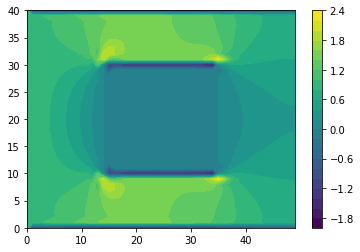

In [19]:
plt.contourf(u.T,levels = 20)
plt.savefig('u/i.png')
plt.colorbar()

(49, 39)
(49, 39)


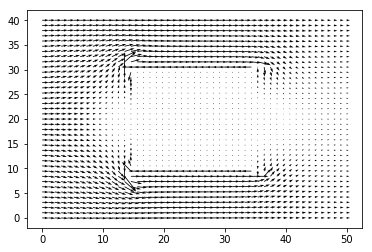

In [11]:
vel_U=u[1:M,1:N]#.transpose()
print(vel_U.shape)
vel_V=v[1:M,1:N]#.transpose()
print(vel_V.shape)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig, ax = plt.subplots()
X, Y = np.mgrid[0:50:49j, 0:40:39j]
ax.quiver(X, Y ,vel_U,vel_V)

plt.show()

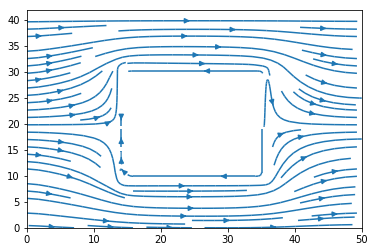

In [12]:
Y, X= np.mgrid[0:40:39j, 0:50:49j]
plt.streamplot(X,Y,vel_U.transpose(), vel_V.transpose())
plt.show()

In [20]:
def Update_T(u,v,T): 
    for i in range(1,M):
        for j in range(1,N):
            if i in list(range(15,36)) and j in list(range(10,31)):
                k=1
                q=2
            else:
                q=0
                k=0.8
#             duTdx = 1/dx * ( u[i,j] * (T[i+1,j]+T[i,j])/2 - u[i-1,j] * (T[i,j] + T[i-1,j])/2 )
#             dvTdy = 1/dy * ( v[i,j] * (T[i,j+1]+T[i,j])/2 - v[i,j-1] * (T[i,j] + T[i,j-1])/2 )
#             T[i,j] = T[i,j] + dt *(k/(cp * rho) * 1/dx**2 * (T[i+1,j]+T[i-1,j]+T[i,j+1]+T[i,j-1]-4*T[i,j]) + q/cp - duTdx - dvTdy)    

            duTdx = (u[i,j] + u[i-1,j])/2 * ((T[i+1,j] + T[i,j])/2 - (T[i,j] + T[i-1,j])/2) /dx
            dvTdy = (v[i,j] + v[i,j-1])/2 * ((T[i,j] + T[i,j+1])/2 - (T[i,j] + T[i,j-1])/2) /dy 
            T[i,j] = T[i,j] + dt *(k/(cp * rho) * 1/dx**2 * (T[i+1,j]+T[i-1,j]+T[i,j+1]+T[i,j-1]-4*T[i,j]) + q/cp - duTdx - dvTdy)
    # update BC
    # left
    T[0,:]=298
    # right
    T[M,:]=T[M-1,:]
    # top
    T[:,N]=T[:,N-1]
    # bottom
    T[:,0]=T[:,1]

    #BC for cell
    #left
#     T[15,10:31]=T[14,10:31]
#     # right
#     T[35,10:31]=T[36,10:31]
#     # top
#     T[15:36,30]=T[15:36,31]
#     # bottom
#     T[15:36,10]=T[15:36,9]
    return T

In [21]:
T=np.ones((M+1, N+1))*0
## middle
T[15:36,10:31]=np.ones((36-15,31-10))*360
T[0,:]=np.ones(N+1)*280
k=1.4
cp=1
q=0

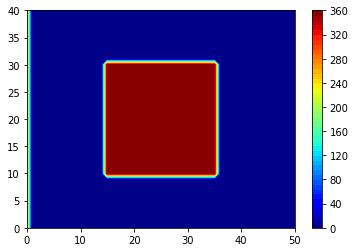

In [22]:
plt.contourf(T.T,levels = 50,cmap='jet')
plt.colorbar()

In [23]:
u_=copy.deepcopy(u)
v_=copy.deepcopy(v)
u_[15:36,10:31]=np.zeros((36-15,31-10))
v_[15:36,10:31]=np.zeros((36-15,31-10))


In [24]:
# t=0
# LIM = np.linspace(60, 400, 10, endpoint=True)
for i in tqdm(range(1000)):
    T=Update_T(u_,v_,T)
#     plt.contourf(T[1:50,1:40].T,levels = 25,cmap='jet',vmin=280, vmax=400)
#     plt.colorbar()
#     plt.savefig('T/%04d.png' % i)
#     plt.cla()
#     if i %10==0:
#         t+=1       
#         plt.contourf(T[1:50,1:40].T,levels = 3,cmap='jet',vmin=60, vmax=400)
# #         plt.colorbar(ticks=v)
#         plt.savefig('T/%d.png'%t)

100%|██████████| 1000/1000 [00:15<00:00, 63.41it/s]


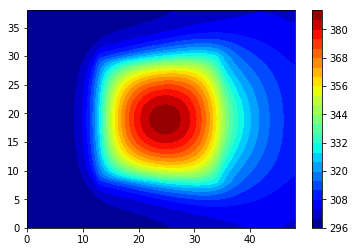

In [43]:
plt.contourf(T[1:50,1:40].T,levels = 25,cmap='jet')
plt.colorbar()